<div align="center">
    <h1> Optimization - Gradients </h1>
</div>

In this notebook, we will present the concept of gradients and how they are used in optimization algorithms.

# Table of Contents
1. [Important misc](#important-misc)
2. [Gradient Descent](#gradient-descent)
3. [Steepest Descent](#steepest-descent)
4. [Conjugate Directions](#conjugate-directions)
5. [Conjugate Gradient](#conjugate-gradient)
6. [Stochastic Gradient Descent](#stochastic-gradient-descent)
7. [Gradient Descent with Momentum](#gradient-descent-with-momentum)
8. [Nesterov Accelerated Gradient](#nesterov-accelerated-gradient)
9. [Newton's Method](#newtons-method)
10. [Adam Optimization](#adam-optimization)
11. [Batch Gradient Descent](#batch-gradient-descent)
12. [Mini-Batch Gradient Descent](#mini-batch-gradient-descent)
13. [Simplex Method](#simplex-method)

## Important misc <a name="important-misc"></a>

The main criterias to stop the optimization algorithms are:
- $||\nabla f(x)|| < \epsilon$
- $||x_{k+1} - x_k|| < \epsilon$
- $|f(x_{k+1}) - f(x_k)| < \epsilon$

In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [39]:
def plot_func(func, x, y, x_start, x_min, trajectory, type=1):
    '''
    Function to plot the contour and the optimization trajectory

    Parameters:
    func - function to optimize
    x_start - starting point
    x_min - minimum point
    trajectory - optimization trajectory
    type - type of contour -> 1 for cmap='viridis' and 2 for 'royalblue square style'
    '''
    plt.close('all')
    arx = plt.figure().add_subplot(projection='3d')
    X, Y = np.meshgrid(x, y)

    if type == 2:
        arx.plot_surface(X, Y, func([X, Y]), edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, alpha=0.3)
    else:
        arx.contour3D(X, Y, func([X, Y]), 60, cmap='viridis')

    arx.set_xlabel('x')
    arx.set_ylabel('y')
    arx.set_zlabel('f(x, y)')

    
    arx.scatter(x_start[0], x_start[1], func(x_start), color='red')
    arx.scatter(x_min[0], x_min[1], func(x_min), color='black')
    arx.plot(trajectory[:, 0], trajectory[:, 1], func(trajectory.T), color='red')
    arx.view_init(40, 10)
    plt.show()

> **Note**: You can try other functions if you want. [Here](https://www.sfu.ca/~ssurjano/optimization.html)

In [40]:
#Choose the function which you want to plot

def func(x):
    # Function 1
    # return x[0]**2 + x[1]**2

    # Function 2
    return 0.5*(x[0] - 4.5)**2 + 2.5*(x[1] - 2.3)**2

    # Matyas function
    # return 0.26*(x[0]**2 + x[1]**2) - 0.48*x[0]*x[1]

def func_grad(x):
    # Function 1
    # return np.array([2*x[0], 2*x[1]])

    # Function 2
    return np.array([x[0] - 4.5, 5*(x[1] - 2.3)])

    # Matyas function
    # return np.array([0.52*x[0] - 0.48*x[1], 0.52*x[1] - 0.48*x[0]])


def func_hessian(x):
    # Function 2
    return np.array([[1, 0], [0, 5]])

    # Matyas function
    # return np.array([[0.52, -0.48], [-0.48, 0.52]])



In [71]:
# LOSS Functions for SGD, Mini-batch GD and Batch GD

# Loss functions for regression
def square_loss(y, y_pred):
    return (y - y_pred)**2

def gradient_square_loss(y, y_pred, x):
    return -2 * (y - y_pred)[:, np.newaxis] * x

# Loss functions for classification
def cross_entropy_loss(y, y_pred):
    return -y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred)

def gradient_cross_entropy_loss(y, y_pred, x):
    return (y_pred - y)[:, np.newaxis] * x

## The method of Gradient Descent <a name="gradient-descent"></a>

The gradient descent method is an optimization algorithm that in most of the cases is used to find the global minimum of a function. The function used is:

<div align="center">

$x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})$

</div>

The parameters are:
* `x_start`: the initial point
* `alpha`: the learning rate
* `epsilon`: the stopping criteria
* `func_gradient`: the gradient of the function
* `breakpoint` (optional): choose which stopping criteria to use

Minimum point: [4.499787   2.30000001]
Number of steps: 30


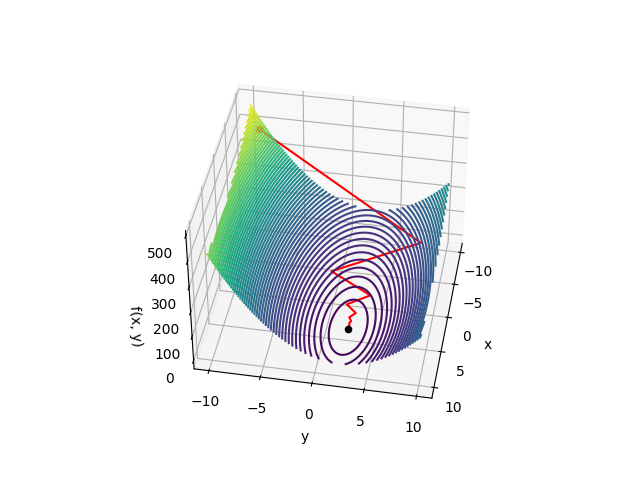

In [54]:
def descent(x, func_gradient, alpha, epsilon, breakpoint='derivative'):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while True:

        x_new = x - alpha * func_gradient(x)

        if breakpoint == 'gradient':
            if abs(func(x_new)) < epsilon:
                break
        elif breakpoint == 'function':
            if abs(func(x) - func(x_new)) < epsilon:
                break
        elif breakpoint == 'steps':
            if np.linalg.norm(x - x_new) < epsilon:
                break

        # Uncomment to see the steps
        # print('Step:', i, 'x:', x, 'f(x):', func(x))
        
        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x])
    
    return x_new, trajectory.reshape(-1, 2), i

# Starting variables
x_start = np.array([-9, -9])
alpha = 0.3
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = descent(x_start, func_grad, alpha, epsilon, breakpoint='steps')

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## The method of Steepest Descent

We consider $x^{(0)}$ to be the initial point. Then the formula for the steepest descent is:

<div align="center">

$x^{(k+1)} = x^{(k)} - \alpha_k \nabla f(x^{(k)})$

</div>

where

<div align="center">

$\alpha_k = \arg \min_{\alpha \geq 0} f(x^{(k)} - \alpha \nabla f(x^{(k)})$

</div>

As $\alpha_k$ requires a line search which is computationally expensive, we can use :
<div align="center">

$f(x_k + \alpha_k p_k) \leq f(x_k) - c_1 * \alpha_k \nabla f(x_k)^T p_k$ &nbsp; &nbsp; <b>(SDC)</b>  <br>
$\nabla f(x_k + \alpha_k p_k)^T p_k \geq c_2 \nabla f(x_k)^T p_k$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <b>(CC)</b>

</div>

with $0 < c_1 < c_2 < 1$.

This conditions are called Wolfe Conditions for Line Search. The first condition is called Armijo Rule (or sufficient decrease condition(SDC)) and the second condition is called curvature condition(CC).


Minimum point: [4.49975864 2.3       ]
Number of steps: 37
Alpha values: [1.   0.25 0.25] ... [0.25 0.25 0.25]


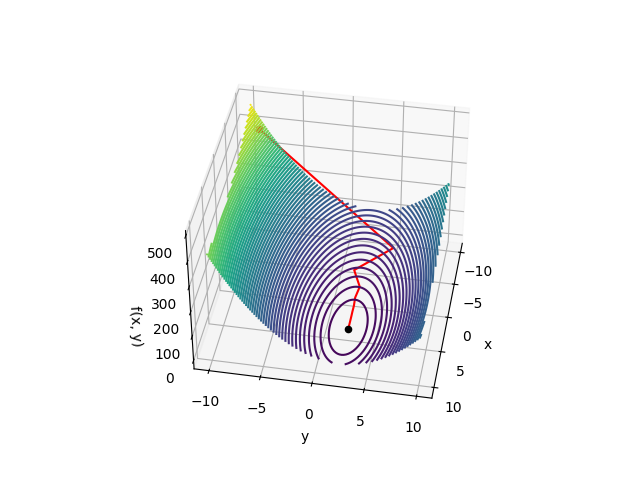

In [53]:
def sufficient_decrease_rule(x_k, alpha, func, func_gradient, c=10**-4, epsilon=10**-6):
    '''
    Backtracking line search using the SDC

    Parameters:
    x_k - current point
    alpha - step size
    func - function to optimize
    func_gradient - gradient of the function
    c - constant (default 10^-4)
    p - constant (default 0.5)
    epsilon - tolerance (default 10^-6)

    Returns:
    aplha - the new step size  
    
    '''
    while func(x_k - alpha * func_gradient(x_k)) > func(x_k) - c * alpha * func_gradient(x_k).T @ func_gradient(x_k):
        alpha /= 2
    
        if alpha < epsilon:
            break

    return alpha

def steepest_descent(x, func_gradient, epsilon, max_iter=10000, breakpoint='derivative'):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    alpha = 1.0
    alpha_values = np.array([alpha])
    i = 0

    while i < max_iter:

        # Calculate the alpha using the Armijo rule
        alpha = sufficient_decrease_rule(x, alpha, func, func_gradient)
        x_new = x - alpha * func_gradient(x)

        # Store the values
        alpha_values = np.append(alpha_values, alpha)
        trajectory = np.append(trajectory, [x], axis=0)

        if breakpoint == 'gradient':
            if abs(func(x_new)) < epsilon:
                break
        elif breakpoint == 'function':
            if abs(func(x) - func(x_new)) < epsilon:
                break
        elif breakpoint == 'steps':
            if np.linalg.norm(x - x_new) < epsilon:
                break

        # Uncomment to see the steps
        # print('Step:', i, 'x:', x, 'f(x):', func(x))
        
        i += 1
        x = x_new     
    
    return x_new, trajectory.reshape(-1, 2), i, alpha_values


'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps, alpha_values = steepest_descent(x_start, func_grad, epsilon, breakpoint='steps')

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Limit the values of alpha to print
if alpha_values.size > 10:
    print('Alpha values:', alpha_values[:3], '...', alpha_values[-3:])
else:
    print('Alpha values:', alpha_values)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## Conjugate Direction Method

We consider $x^{(0)}$ to be the initial point and $d^{(0)},d^{(1)},...,d^{(n-1)}, n$ directions Q-conjugated. For $k = 0,1,...,$ we have:

<div align="center">

$g^{(k)} = \nabla f(x^{(k)}) = Qx^{(k)} - b$ <br><br>
$\alpha_k = - \frac{(g^{(k)})^Td^{(k)}}{(d^{(k)})^TQd^{(k)}}$ <br><br>
$x^{(k+1)} = x^{(k)} + \alpha_k d^{(k)}$
</div>

Alpha: -0.25
Alpha: 2.0
Minimum point: [-1.   1.5]
Number of steps: 2
Trajectory: [[ 0.    0.  ]
 [-0.25  0.  ]
 [-1.    1.5 ]]


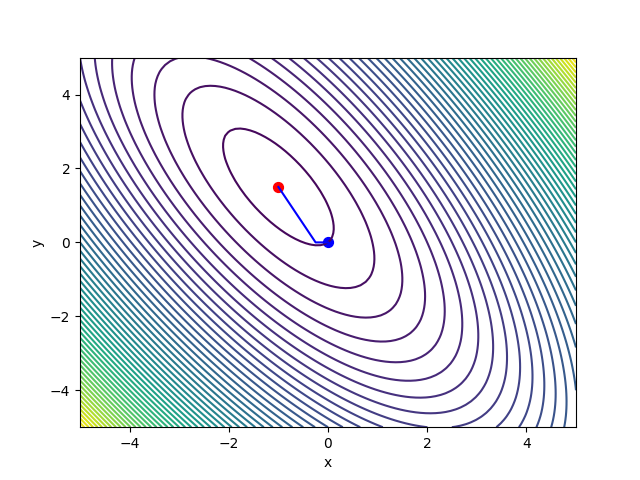

In [55]:
def conjugate_direction(x, Q, beta, epsilon, direction, max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while i < max_iter:
        p = Q @ x - beta
        alpha = - (p.T @ direction[i]) / (direction[i].T @ Q @ direction[i])

        print('Alpha:', alpha)

        x_new = x + alpha * direction[i]

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory.reshape(-1, 2), i

'''Starting variables'''
x_start = np.array([0, 0])
epsilon = 0.0001
Q = np.array([[4, 2], [2, 2]])
b = np.array([-1, 1])
dir = np.array([[1, 0], [-3/8, 3/4]])
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)

def func_matrix_from(x, Q=Q, beta=b):
    return 0.5 * x.T @ Q @ x - x.T @ beta

def func_grad_matrix_form(x, Q=Q, beta=b):
    return Q @ x - beta

# Calling the function
x_min, trajectory, steps = conjugate_direction(x_start, Q, b, epsilon, dir, max_iter=2)

print('Minimum point:', x_min)
print('Number of steps:', steps)
print('Trajectory:', trajectory)

# Plot the function
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func_matrix_from(np.array([X[i, j], Y[i, j]]))

plt.close('all')
plt.contour(X, Y, Z, 60, cmap='viridis')
plt.scatter(x_start[0], x_start[1], color='blue', s=50)
plt.scatter(x_min[0], x_min[1], color='red', s=50)
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Conjugate Gradient Method

We consider $x^{(0)}$ to be the initial point.

We choose:
<div align="center">

$d^{(0)} = \nabla f(x^{(0)}) = -g^{(0)}$

</div>

At k-th step, we have:
<div align="center">

$g^{(k)} = \nabla f(x^{(k)})$ <br><br>
$d^{(k)} = -g^{(k)} + \beta_{k-1} d^{(k-1)}$ <br><br>
$\beta_{k-1} = \frac{(g^{(k)})^TQd^{(k-1)}}{(d^{(k-1)})^TQd^{(k-1)}}$ <br><br>
$\alpha_k = - \frac{(g^{(k)})^Td^{(k)}}{(d^{(k)})^TQd^{(k)}}$

</div>

Each step becomes:
<div align="center">

$x^{(k+1)} = x^{(k)} + \alpha_k d^{(k)}$

</div>

Alpha: 0.20903149874562518
Alpha: 0.9567935990517114
Minimum point: [4.5 2.3]
Number of steps: 2
Trajectory: [[-9.         -9.        ]
 [-6.17807477  2.81027968]
 [ 4.5         2.3       ]]


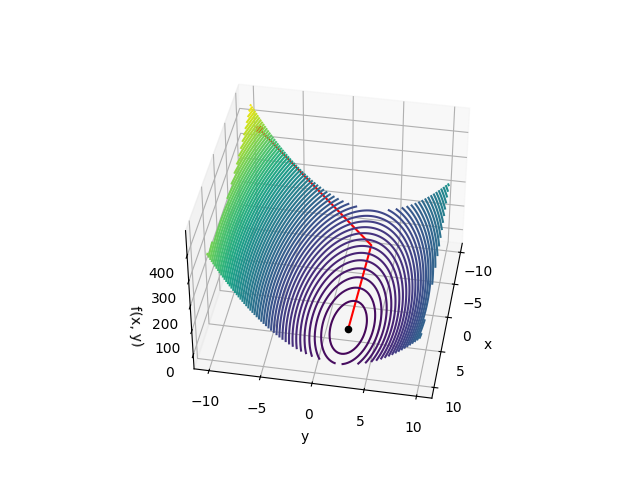

In [56]:
def conjugate_gradient(x, Q, b, epsilon, max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while i < max_iter:
        p = Q @ x - b

        if i == 0:
            d = -p
        else:
            beta = (p.T @ Q @ d) / (d.T @ Q @ d)
            d = -p + beta * d

        # If the denominator is too small, break the loop
        denominator = d.T @ Q @ d
        if np.abs(denominator) < 10**-10:
            break

        alpha = (-1) * (p.T @ d) / denominator

        print('Alpha:', alpha)

        x_new = x + alpha * d

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory.reshape(-1, 2), i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
Q = np.array([[1, 0], [0, 5]])
b = np.array([4.5, 11.5])
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

def func_matrix_from(x, Q=Q, b=b):
    return 0.5 * x.T @ Q @ x - b.T @ x

def func_grad_matrix_form(x, Q=Q, b=b):
    return Q @ x - b

# Calling the function
x_min, trajectory, steps = conjugate_gradient(x_start, Q, b, epsilon, max_iter=5)

print('Minimum point:', x_min)
print('Number of steps:', steps)
print('Trajectory:', trajectory)

# Plot the function
arx = plt.figure().add_subplot(projection='3d')
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = func_matrix_from(np.array([X[i, j], Y[i, j]]))

arx.contour3D(X, Y, Z, 60, cmap='viridis')

arx.set_xlabel('x')
arx.set_ylabel('y')
arx.set_zlabel('f(x, y)')

# Check if the minimum point is nan
if np.isnan(x_min).any():
    x_min = trajectory[-1]
    
arx.scatter(x_start[0], x_start[1], func_matrix_from(x_start), color='red')
arx.scatter(x_min[0], x_min[1], func_matrix_from(x_min), color='black')

z_trajectory = [func_matrix_from(x) for x in trajectory]
arx.plot(trajectory[:, 0], trajectory[:, 1], z_trajectory, color='red')
arx.view_init(40, 10)
plt.show()

## Stochastic Gradient Descent

Firstly we consider a set of ${(a_i, y_i)}_{i=1..n}$ , where $a_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$ follows an unknown distribution. We want to find a function $h: \mathbb{R}^d \rightarrow \mathbb{R}$ that minimizes the expected loss.

So, we follow the classical algorithm of gradient descent:

$$x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})$$

and we consider

$$ \nabla f(x^{(k)}) = \frac{1}{| \xi |} \sum_{i \in \xi} \nabla l(a_i, y_i, h(x^{(k)}))$$

where $\xi$ is a random subset of $\{1, 2, ..., n\}$ and $l$ is the loss function.


Here are some examples of loss functions:

* Square loss (loss function used in linear regression)

$l_{squared}(x,y,h) = (y - h(x))^2$

* Cross-entropy loss (loss function used in classification)

$l(x,y,h) = -y \log(h(x)) - (1 - y) \log(1 - h(x))$

> For stochastic gradient descent, the batch size is **1**.

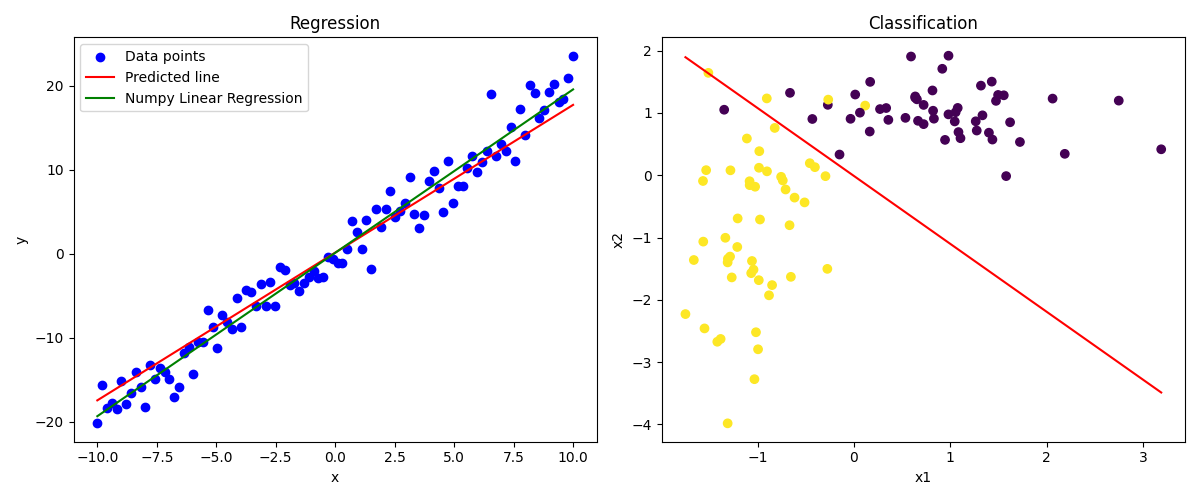

In [70]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def stochastic_gradient_descent(x, y, alpha,  batch_size, epsilon, gradient_loss_func, model_type='regression', max_iter=100):
    x_new = np.zeros(x.shape[1])
    i = 0

    while i < max_iter:
        # Randomly select the batch
        idx = np.random.choice(len(y), batch_size, replace=False)
        x_batch = x[idx]
        y_batch = y[idx]

        if model_type == 'regression':
            y_pred = x_batch @ x_new
        elif model_type == 'classification':
            y_pred = sigmoid(x_batch @ x_new)

        gradient = (1 / batch_size) * np.sum(gradient_loss_func(y_batch, y_pred, x_batch), axis=0)

        x_new = x_new - alpha * gradient

        if np.linalg.norm(gradient) < epsilon:
            break
        
        i += 1
    
    return x_new

'''Starting variables'''
epsilon = 0.0001
alpha = 0.01
batch_size = 1

# Regression variables
x = np.linspace(-10, 10, 100).reshape(-1, 1)
x = np.hstack((x, np.ones_like(x)))
y = 2 * x[:, 0] + np.random.normal(0, 1, 100) * 2 # y = 2x + noise
m_np, b_np = np.polyfit(x[:, 0], y, 1) # Numpy linear regression

# Classification variables
x_class, y_class = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=49)
x_class = np.hstack((x_class, np.ones((x_class.shape[0], 1))))

plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
x_min1 = stochastic_gradient_descent(x, y, alpha, batch_size, epsilon, gradient_square_loss, model_type='regression')
ax1.scatter(x[:, 0], y, color='blue')
ax1.plot(x[:, 0], x_min1[0] * x[:, 0] + x_min1[1], color='red')
ax1.plot(x[:, 0], m_np * x[:, 0] + b_np, color='green')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Regression')
ax1.legend(['Data points', 'Predicted line', 'Numpy Linear Regression'], loc='upper left')

# Classification plot
x_min2 = stochastic_gradient_descent(x_class, y_class, alpha, batch_size, epsilon, gradient_cross_entropy_loss, model_type='classification')
ax2.scatter(x_class[:, 0], x_class[:, 1], c=y_class, cmap='viridis')

# Decision boundary
x_class_vals = np.linspace(min(x_class[:, 0]), max(x_class[:, 0]), 100)
y_class_vals = -(x_min2[0] * x_class_vals + x_min2[2]) / x_min2[1]
ax2.plot(x_class_vals, y_class_vals, color='red')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Classification')

plt.tight_layout()
plt.show()

## Gradient Descent with Momentum

<div align="center">

$m^{(k+1)} = \gamma_k m^{(k)} + (1 - \gamma_k) \nabla f(x^{(k)})$ <br><br>
$x^{(k+1)} = x^{(k)} - \alpha_k m^{(k+1)}$

</div>

or, equivalently:
<div align="center">

$x^{(k+1)} = x^{(k)} - \tilde{\alpha}_k \nabla f(x^{(k)}) + \tilde{\beta}_k (x^{(k)} - x^{(k-1)})$ <br><br>
$\tilde{\alpha}_k = \alpha_k ( 1 - \gamma_k)$ &nbsp; &nbsp; $\tilde{\beta}_k = \frac{\alpha_k \gamma_k}{\alpha_{k-1}}$

Minimum point: [4.51670807 2.31419207]


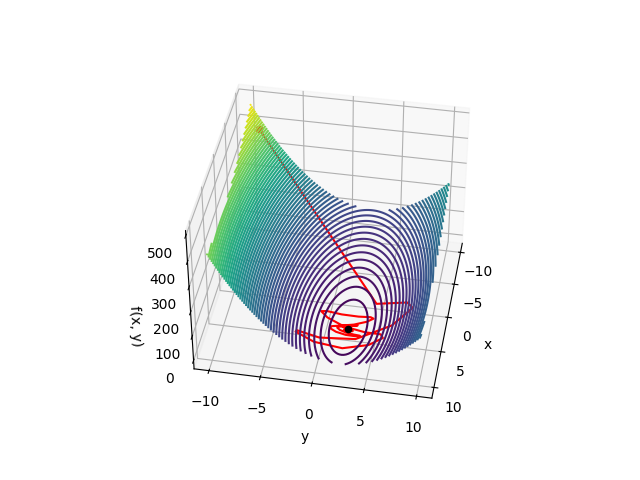

In [58]:
def gradient_descent_momentum(x, alpha, gamma, func_gradient, epsilon, solve_type='1', max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    m = np.zeros(x.shape)
    i = 0
    alpha_prev = 0
    x_prev = 0

    while i < max_iter:

        if solve_type == '1':
            m = gamma * m + (1 - gamma) * func_gradient(x)
            x_new = x_new - alpha * m

        elif solve_type == '2':
            alpha_modif = alpha * (1 - gamma)

            if i == 0:
                beta_modif = 0
            else:
                beta_modif = (alpha * gamma) / alpha_prev

            x_new = x - alpha_modif * func_gradient(x) + beta_modif * (x - x_prev)

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        alpha_prev = alpha
        x_prev = x
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory, i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
alpha = 0.8
gamma = 0.9
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = gradient_descent_momentum(x_start, alpha, gamma, func_grad, epsilon, solve_type='1')

print('Minimum point:', x_min)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## Nesterov's Accelerated Gradient

$$
\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - \alpha_k \nabla f\left( \mathbf{x}^{(k)} + \beta_k \left( \mathbf{x}^{(k)} - \mathbf{x}^{(k-1)} \right) \right) + \beta_k \left( \mathbf{x}^{(k)} - \mathbf{x}^{(k-1)} \right)
$$

- $\alpha_k$ is the step size, determined by the Lipschitz constant $L$
- $\beta_k = \frac{\lambda_{k-1} - 1}{\lambda_k}$ is the momentum parameter
- $\lambda_k = \frac{1 + \sqrt{1 + 4\lambda_{k-1}^2}}{2}$ ensures optimal convergence
- $\nabla f(\mathbf{x})$ is the gradient of the function

For a convex function with an **L-Lipschitz continuous gradient**, the convergence bound is given by:

$$
 f(\mathbf{x}^{(k)}) - f(\mathbf{x}^*) \leq \frac{2L}{(k+1)^2} \|\mathbf{x}^{(0)} - \mathbf{x}^*\|^2.
$$

- [Lipschitz Constant - Mathworks](https://www.mathworks.com/matlabcentral/answers/124593-how-to-calculate-lipschitz-constant)
- [Lipschitz Constant Estimator using Sparse Polinomial Optimization](https://openreview.net/pdf?id=rJe4_xSFDB)

Minimum point: [4.49969739 2.29999684]
Number of steps: 49


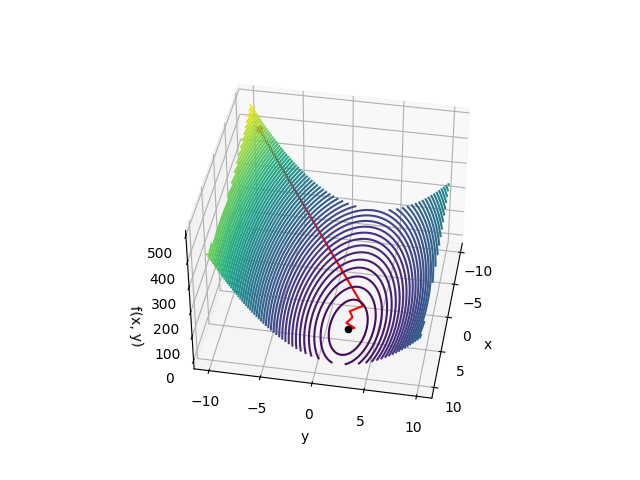

In [59]:
def dual_norm(x):
    return np.sqrt(np.sum(x**2))

def estimate_lipschitz(func_gradient, x, x_prev):
    return dual_norm(func_gradient(x) - func_gradient(x_prev)) / dual_norm(x - x_prev)
    

def nesterov_accelerated_gradient(x, func_gradient, epsilon, max_iter=100):
    x_new, x_prev = np.zeros(x.shape), np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0
    lambda_prev = 0

    while i < max_iter:
        # L-lipschitz gradient
        L = estimate_lipschitz(func_gradient, x, x_prev)

        if L == 0:
            alpha = 1
        else:
            alpha = 1 / L

        lambda_new = (1 + np.sqrt(1 + 4 * lambda_prev**2)) / 2
        beta = (lambda_prev - 1) / lambda_new

        x_new = x - alpha * func_gradient(x + beta * (x - x_prev)) + beta * (x - x_prev)
        
        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        lambda_prev = lambda_new
        x_prev = x
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory, i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = nesterov_accelerated_gradient(x_start, func_grad, epsilon, max_iter=1000)

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## Newton's Method

The second-order approximation of the function $ f(x) $ around $ x^{(k)} $ is given by:

$$
f(x) \approx f\left(x^{(k)}\right) + \left(\mathbf{g}^{(k)}\right)^T \left(x - x^{(k)}\right) + \frac{1}{2} \left(x - x^{(k)}\right)^T \nabla^2 f\left(x^{(k)}\right) \left(x - x^{(k)}\right)
$$
<br>

If we note $ q(x) = f\left(x^{(k)}\right) + \left(\mathbf{g}^{(k)}\right)^T \left(x - x^{(k)}\right) + \frac{1}{2} \left(x - x^{(k)}\right)^T \nabla^2 f\left(x^{(k)}\right) \left(x - x^{(k)}\right) $, we can find the minimum of $ q(x) $ by solving:

$$
0 = \nabla q(x) = \mathbf{g}^{(k)} + \nabla^2 f\left(x^{(k)}\right) \left(x - x^{(k)}\right)
$$
<br><br>
Assuming $ \nabla^2 f(x^{(k)}) \succ 0 $, we can solve for $ x $:

$$
x^{(k+1)} = x^{(k)} - \left(\nabla^2 f\left(x^{(k)}\right)\right)^{-1} \mathbf{g}^{(k)}
$$



Minimum point: [4.5 2.3]
Number of steps: 1


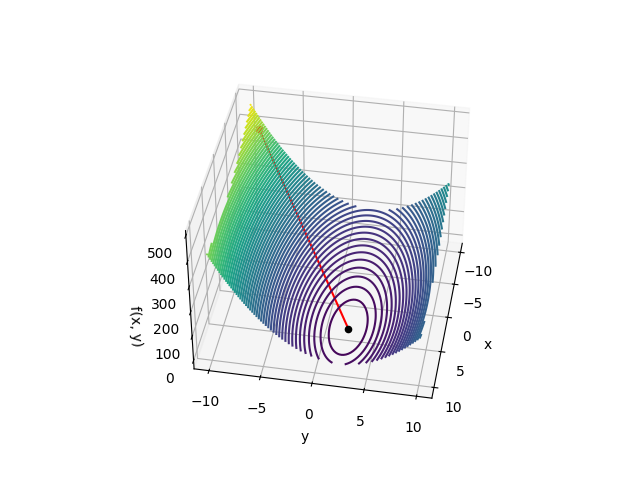

In [67]:
def newton_method(x, func_gradient, func_hessian, epsilon, max_iter=100):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    i = 0

    while i < max_iter:
        x_new = x - np.linalg.inv(func_hessian(x)) @ func_gradient(x)

        x_new = np.clip(x_new, -10, 10)

        if np.linalg.norm(x - x_new) < epsilon:
            break

        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory, i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = newton_method(x_start, func_grad, func_hessian, epsilon, max_iter=1000)

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## Adam Optimization

For each parameter $ x_t $:

$$
g_t = \nabla f(x_t)
$$
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$
$$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}, \quad \hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$$
$$
x_{t+1} = x_t - \frac{\alpha \hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon}
$$

where:
- $ \beta_1 $ and $ \beta_2 $ are decay rates for **momentum** and **variance**, respectively.
- $ \alpha $ is the **learning rate**.
- $ \epsilon $ is a small value to avoid division by zero.
<br><br>

- [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)

Minimum point: [4.50125104 2.29960892]
Number of steps: 184


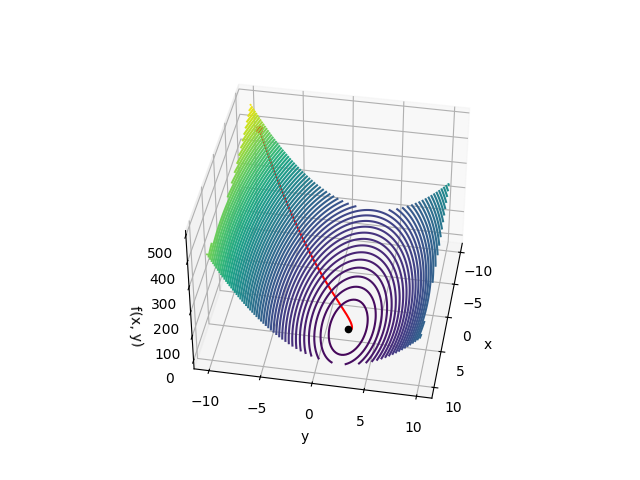

In [61]:
def adam_optimization(x, alpha, beta1, beta2, epsilon, func_gradient):
    x_new = np.zeros(x.shape)
    trajectory = np.array([x])
    m = np.zeros(x.shape)
    v = np.zeros(x.shape)
    i = 0
    convergence = False

    while not convergence:
        m = beta1 * m + (1 - beta1) * func_gradient(x)
        v = beta2 * v + (1 - beta2) * func_gradient(x)**2

        m_hat = m / (1 - beta1**(i + 1))
        v_hat = v / (1 - beta2**(i + 1))

        x_new = x - alpha * m_hat / (np.sqrt(v_hat) + epsilon)

        if np.linalg.norm(func_gradient(x)) < epsilon:
            convergence = True

        if np.linalg.norm(x - x_new) < epsilon:
            convergence = True

        i += 1
        x = x_new
        trajectory = np.append(trajectory, [x], axis=0)

    return x_new, trajectory, i

'''Starting variables'''
x_start = np.array([-9, -9])
epsilon = 0.0001
alpha = 0.3
beta1 = 0.9
beta2 = 0.999
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)

# Calling the function
x_min, trajectory, steps = adam_optimization(x_start, alpha, beta1, beta2, epsilon, func_grad)

print('Minimum point:', x_min)
print('Number of steps:', steps)

# Plot the function
plot_func(func, x, y, x_start, x_min, trajectory, type=1)

## Batch Gradient Descent

Firstly we consider a set of ${(a_i, y_i)}_{i=1..n}$ , where $a_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$ follows an unknown distribution. We want to find a function $h: \mathbb{R}^d \rightarrow \mathbb{R}$ that minimizes the expected loss.

So, we follow the classical algorithm of gradient descent:

$$x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})$$

and we consider

$$ \nabla f(x^{(k)}) = \frac{1}{| \xi |} \sum_{i \in \xi} \nabla l(a_i, y_i, h(x^{(k)}))$$

where $\xi$ is a random subset of $\{1, 2, ..., n\}$ and $l$ is the loss function.


Here are some examples of loss functions:

* Square loss (loss function used in linear regression)

$l_{squared}(x,y,h) = (y - h(x))^2$

* Cross-entropy loss (loss function used in classification)

$l(x,y,h) = -y \log(h(x)) - (1 - y) \log(1 - h(x))$

> For batch gradient descent, the batch size is **the whole set**.

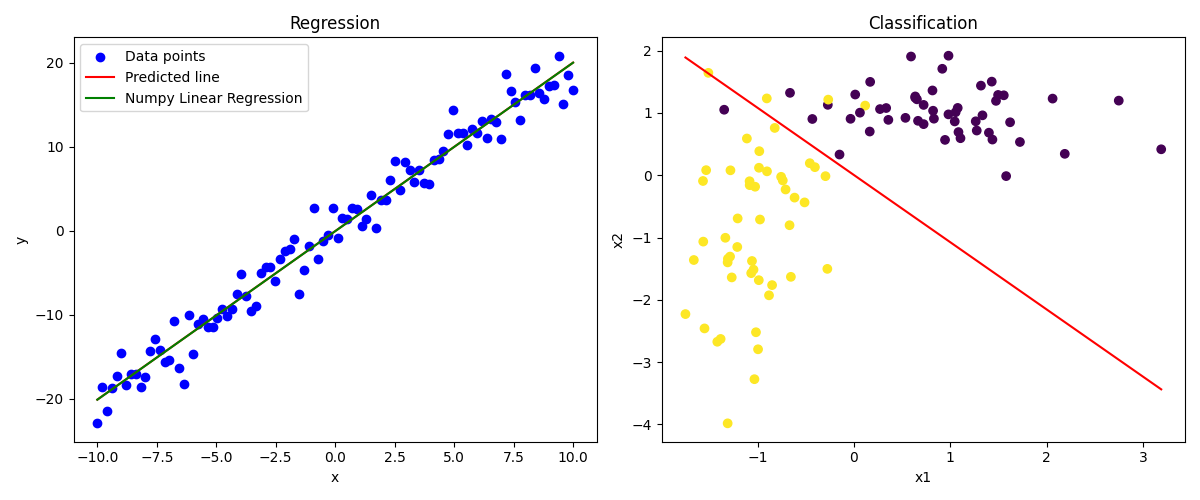

In [69]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def batch_gradient_descent(x, y, alpha, epsilon, gradient_loss_func, model_type='regression', max_iter=100):
    x_new = np.zeros(x.shape[1])
    i = 0

    while i < max_iter:
        if model_type == 'regression':
            y_pred = x @ x_new
        elif model_type == 'classification':
            y_pred = sigmoid(x @ x_new)

        gradient = (1 / len(y)) * np.sum(gradient_loss_func(y, y_pred, x), axis=0)

        x_new = x_new - alpha * gradient

        if np.linalg.norm(gradient) < epsilon:
            break
        
        i += 1
    
    return x_new

'''Starting variables'''
epsilon = 0.0001
alpha = 0.01

# Regression variables
x = np.linspace(-10, 10, 100).reshape(-1, 1)
x = np.hstack((x, np.ones_like(x)))
y = 2 * x[:, 0] + np.random.normal(0, 1, 100) * 2 # y = 2x + noise
m_np, b_np = np.polyfit(x[:, 0], y, 1) # Numpy linear regression

# Classification variables
x_class, y_class = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=49)
x_class = np.hstack((x_class, np.ones((x_class.shape[0], 1))))

plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
x_min1 = batch_gradient_descent(x, y, alpha, epsilon, gradient_square_loss, model_type='regression')
ax1.scatter(x[:, 0], y, color='blue')
ax1.plot(x[:, 0], x_min1[0] * x[:, 0] + x_min1[1], color='red')
ax1.plot(x[:, 0], m_np * x[:, 0] + b_np, color='green')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Regression')
ax1.legend(['Data points', 'Predicted line', 'Numpy Linear Regression'], loc='upper left')

# Classification plot
x_min2 = batch_gradient_descent(x_class, y_class, alpha, epsilon, gradient_cross_entropy_loss, model_type='classification')
ax2.scatter(x_class[:, 0], x_class[:, 1], c=y_class, cmap='viridis')

# Decision boundary
x_class_vals = np.linspace(min(x_class[:, 0]), max(x_class[:, 0]), 100)
y_class_vals = -(x_min2[0] * x_class_vals + x_min2[2]) / x_min2[1]
ax2.plot(x_class_vals, y_class_vals, color='red')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Classification')

plt.tight_layout()
plt.show()

## Mini-Batch Gradient Descent

Firstly we consider a set of ${(a_i, y_i)}_{i=1..n}$ , where $a_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$ follows an unknown distribution. We want to find a function $h: \mathbb{R}^d \rightarrow \mathbb{R}$ that minimizes the expected loss.

So, we follow the classical algorithm of gradient descent:

$$x^{(k+1)} = x^{(k)} - \alpha \nabla f(x^{(k)})$$

and we consider

$$ \nabla f(x^{(k)}) = \frac{1}{| \xi |} \sum_{i \in \xi} \nabla l(a_i, y_i, h(x^{(k)}))$$

where $\xi$ is a random subset of $\{1, 2, ..., n\}$ and $l$ is the loss function.


Here are some examples of loss functions:

* Square loss (loss function used in linear regression)

$l_{squared}(x,y,h) = (y - h(x))^2$

* Cross-entropy loss (loss function used in classification)

$l(x,y,h) = -y \log(h(x)) - (1 - y) \log(1 - h(x))$

> For mini-batch gradient descent, the batch size is **chosen arbitrarily**.

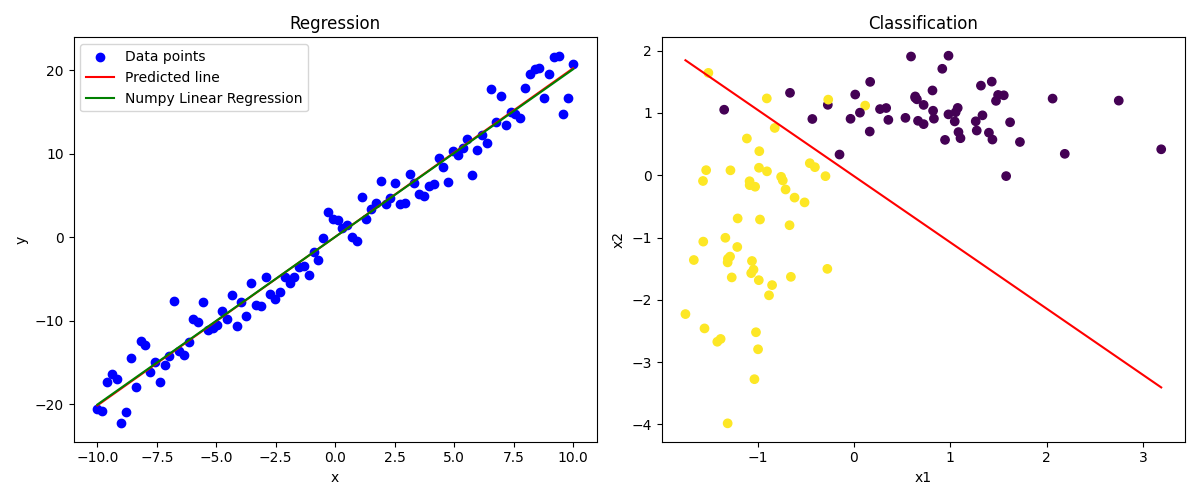

In [72]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mini_batch_gradient_descent(x, y, alpha,  batch_size, epsilon, gradient_loss_func, model_type='regression', max_iter=100):
    x_new = np.zeros(x.shape[1])
    i = 0

    while i < max_iter:
        # Randomly select the batch
        idx = np.random.choice(len(y), batch_size, replace=False)
        x_batch = x[idx]
        y_batch = y[idx]

        if model_type == 'regression':
            y_pred = x_batch @ x_new
        elif model_type == 'classification':
            y_pred = sigmoid(x_batch @ x_new)

        gradient = (1 / batch_size) * np.sum(gradient_loss_func(y_batch, y_pred, x_batch), axis=0)

        x_new = x_new - alpha * gradient

        if np.linalg.norm(gradient) < epsilon:
            break
        
        i += 1
    
    return x_new

'''Starting variables'''
epsilon = 0.0001
alpha = 0.01
batch_size = 32

# Regression variables
x = np.linspace(-10, 10, 100).reshape(-1, 1)
x = np.hstack((x, np.ones_like(x)))
y = 2 * x[:, 0] + np.random.normal(0, 1, 100) * 2 # y = 2x + noise
m_np, b_np = np.polyfit(x[:, 0], y, 1) # Numpy linear regression

# Classification variables
x_class, y_class = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=49)
x_class = np.hstack((x_class, np.ones((x_class.shape[0], 1))))

plt.close('all')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regression plot
x_min1 = mini_batch_gradient_descent(x, y, alpha, batch_size, epsilon, gradient_square_loss, model_type='regression')
ax1.scatter(x[:, 0], y, color='blue')
ax1.plot(x[:, 0], x_min1[0] * x[:, 0] + x_min1[1], color='red')
ax1.plot(x[:, 0], m_np * x[:, 0] + b_np, color='green')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Regression')
ax1.legend(['Data points', 'Predicted line', 'Numpy Linear Regression'], loc='upper left')

# Classification plot
x_min2 = mini_batch_gradient_descent(x_class, y_class, alpha, batch_size, epsilon, gradient_cross_entropy_loss, model_type='classification')
ax2.scatter(x_class[:, 0], x_class[:, 1], c=y_class, cmap='viridis')

# Decision boundary
x_class_vals = np.linspace(min(x_class[:, 0]), max(x_class[:, 0]), 100)
y_class_vals = -(x_min2[0] * x_class_vals + x_min2[2]) / x_min2[1]
ax2.plot(x_class_vals, y_class_vals, color='red')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Classification')

plt.tight_layout()
plt.show()

## Simplex Method

TODO